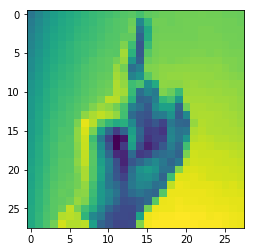

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import time 
import matplotlib.pyplot as plt

train = pd.read_csv('./SignLanguageData/sign_mnist_train.csv')
test = pd.read_csv('./SignLanguageData/sign_mnist_test.csv')

train = train.astype(float)
test = test.astype(float)

Y_train = train['label'].values
train.drop('label', axis = 1, inplace = True)

Y_test = test['label'].values
test.drop('label', axis = 1, inplace = True)

labelizer = LabelEncoder()
Y_train = labelizer.fit_transform(Y_train)
Y_test = labelizer.transform(Y_test)

X_train = train.values
X_test = test.values

pipeline = Pipeline([
            ("std_scale", StandardScaler()),
            ("pca", PCA(.95)),
        ])


X_train_transform = pipeline.fit_transform(X_train, Y_train)
X_test_transform = pipeline.transform(X_test)
plt.imshow(X_train[0].reshape(28,28))
print(X_test.shape)
print(X_train.shape)
print(Y_train[0])
print(Y_test[0])

In [21]:
from sklearn.metrics import classification_report, f1_score
from time import time
from sklearn.model_selection import GridSearchCV

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""          
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'  
            return ret_str          
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
                   
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: data=SignLanguageMnist, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import sys
old_stdout = sys.stdout
sys.stdout = open('output_log.txt', 'w')

model_pipe = Pipeline([
    ("std_scaler", StandardScaler()),
    ("pca", PCA(.95)),
])

tuning_parameters = {
    'solver':('newton-cg', 'saga') # Saga is faster for large datasets
}

model = LogisticRegression()

CV=5
VERBOSE=0

start = time()
random_grid_tuned = GridSearchCV(model, tuning_parameters, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
random_grid_tuned.fit(X_train_transform, Y_train)
t = time()-start

# Report result
# There will be a lot of different combinations and it will take longer for it to search through all combinations. 
b0, m0= FullReport(random_grid_tuned, X_test_transform, Y_test, t)

sys.stdout = old_stdout


/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cross Validation Matrix
[1.         0.99978147 1.        ]
Confusion Matrix
[[1126    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0    0    0    0    0
     0    1    0    0    0    0    0    0    0    0]
 [   0    0 1144    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1196    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  957    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1204    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1090    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1013    0   

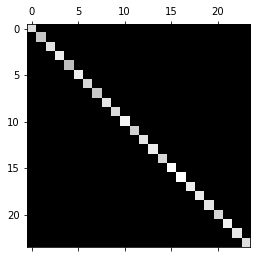

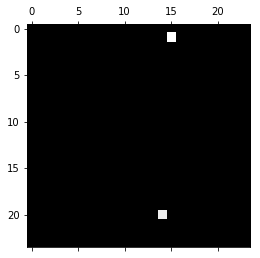

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Best model 
model = LogisticRegression(solver='newton-cg', multi_class='auto')

# Inspiration from page 102 - 105, Chapter 3, 'Hands-On Machine Learning'
print("Cross Validation Matrix")
score = cross_val_score(model, X_train_transform, Y_train, cv=3, scoring="accuracy")
print(score)

print("Confusion Matrix")
Y_pred = cross_val_predict(model, X_train_transform, Y_train, cv=3)
conf_mx = confusion_matrix(Y_train, Y_pred)
print(conf_mx)

# Plot confusion matrix 
plt.matshow(conf_mx, cmap=plt.cm.gray)

# Plot errors 
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() 
